In [1]:
                                                                                                                                                                                                                                                                                        import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
import pathlib
from pathlib import Path
from typing import Tuple, Dict, List

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
                                                                                                                                
import torchvision
from torchvision import transforms
from torchvision import datasets

from tqdm import tqdm
from timeit import default_timer as timer 

### 设置好device，以充分发挥GPU的计算优势，同时要兼容没有GPU的设备

In [2]:
# 数据和模型都要加载到正确的设备上，否则会因不兼容而报错
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# 设置数据文件夹
DATA_PATH = Path("data/")
IMAGE_PATH = DATA_PATH / "wordlib"    #
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*.gif"))  

# 如果文件夹不存在，则创建一个... 
if IMAGE_PATH.is_dir():
    print(f"{IMAGE_PATH} 文件夹存在，可以使用...")
else:
    print(f"{IMAGE_PATH}文件平不存在，创建中...")
    IMAGE_PATH.mkdir(parents=True, exist_ok=True)

data\wordlib 文件夹存在，可以使用...


### 准备数据，查找指定文件夹中包含哪些文字，并设置其classes和labels

In [4]:
# 查找指定文件夹中的classes
def find_classes(directory: str,ext:str='gif') -> Tuple[List[str], Dict[str, int],List[str]]:
    """根据指定文件夹下的图片文件名的第一名字形成类别classes.
    
    书法图片文件命名规范为：字_字体_书法家_文件编号.gif，如：予_行书_鲜于枢_12046.gif.

    Args:
        directory (str): target directory to load distinct words from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        data\wordlib\予_行书_鲜于枢_12046.gif 分割_前面的字符是书法对应的文字
        >>> (["予", "大",...], {"予": 203, ...})
    """
    # 1. 扫描路径下全部文件，通过文件名首字符为图片所对应的汉字这样的命名规则，得到该路径下的全部汉字。
    image_path_list = list(pathlib.Path(directory).glob(f"*.{ext}"))
    image_classes_set = set()  #因为相同的字有多张图，所以使用set集合去重
    images_classes_list=[]
    images_name_list=[]
    for  path in   image_path_list:
        image_classes_set.add(path.name.split('_')[0])
        images_name_list.append(path.name)
    classes=sorted([word for word in image_classes_set])
    
    # 2. 如果文件不存在或没有按要求命名，则报错
    if not classes:
        raise FileNotFoundError(f"{directory}路径下的文件可能不存在或没有按要求命名（文件命名规则为word_font_writer_number.gif)")
        
    # 3. 创建汉字列表及包含其序号的dict
    class_to_idx=dict()
    for i,word in enumerate(classes):
        class_to_idx[word]=i   

    return classes, class_to_idx, images_name_list

### 根据指定文件夹下的图片，生成文字列表，并以Dict保存每个文字的编号

In [5]:
## ，是模型训练的基础数据，重要，不要改动
images_classes_list,word_classes_dict,images_name_list=find_classes(IMAGE_PATH,'gif') 

In [6]:
print(f'文件夹{IMAGE_PATH}下有{len(images_classes_list)}个字的书法图片')

文件夹data\wordlib下有8985个字的书法图片


In [7]:
#以DataFrame形式保存字与Label的对应关系
df_word_label_map=pd.DataFrame.from_dict(word_classes_dict,orient='index',columns=['label'])
df_word_label_map.reset_index(inplace=True)
df_word_label_map.columns=['word','label']
df_word_label_map.T

,0,1,2,3,4,5,6,7,8,9,...,8975,8976,8977,8978,8979,8980,8981,8982,8983,8984
word,一,丁,七,万,丈,三,上,下,不,与,...,龍,龐,龔,龕,龙,龚,龛,龜,龟,龠
label,0,1,2,3,4,5,6,7,8,9,...,8975,8976,8977,8978,8979,8980,8981,8982,8983,8984


### 定义函数resolve_word_by_image_name，根据图片文件名找出对应的文字(class)、标签(Label)，并显示该文字图片

In [8]:
def resolve_word_by_image_name(image_path,word_classes_dict,show=True)->(str,str,Image):
    
    '''
    定义函数 resolve_word_by_image_name，根据图片文件名找出对应的文字(class)、标签(Label)，并显示该文字图片
    Args:
        image_path (str): 文字图片路径和文件名.
        word_classes_dict (dict): 文字及标签的字典
        show (Boolean): 是否显示文字图片

    Returns:
        str,str: 文字class,文字label

    Example:
        data\wordlib\予_行书_鲜于枢_12046.gif "_"前面的字符是书法对应的文字
        返回："予",203
    '''
    image_class = Path(str(image_path)).name.split('_')[0]
    image_label =word_classes_dict[image_class]
    print(f'图片{image_path}对应的文字是：{image_class}, 其label为: {image_label}')
    
    
    with Image.open(image_path).convert('RGB') as f: #    丁_草书_王铎_131029.gif data/wordlib/zxqsig.jpg
        if show:
            plt.figure(figsize=(2,2))
            plt.imshow(f)  
            plt.title(f"图片size(H,W)为:({f.height}, {f.width})",fontsize=16,fontproperties='Simhei')
            plt.axis(False)            
    return image_class,image_label,f

图片data\wordlib\履_行书_王献之_24385_695241_aug.gif对应的文字是：履, 其label为: 1674


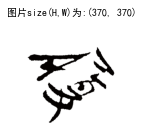

In [9]:
random_image_path = random.choice(IMAGE_PATH_LIST)
word,label,img=resolve_word_by_image_name(random_image_path,word_classes_dict,show=True)

### 创建图片转换Transform，将图片按某种效果进行变换
详见[Pytorch文档: ILLUSTRATION OF TRANSFORMS](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)

In [10]:
# 定义 transform
# 转换效果及使用方法详见：https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
aug_transform = transforms.Compose([
    transforms.Resize((370, 370)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31,fill=255), # how intense 
    #transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.RandomRotation(degrees=(-90, 90),expand=False,fill=255),
    #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.7, 0.9),fill=255),
    #transforms.ElasticTransform(alpha=250.0,fill=255),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.2,fill=255),
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

In [11]:
def plot_one_transformed_image(image_path,transform=None,save=True,save_path='data/augmented/'):
    
    '''
    show_transformed_image，根据图片文件名和Transform，显示原图片和Transformed后的图片
    Args:
        image_path (str): 文字图片路径和文件名,如'data/wordlib/书_行书_王羲之_11946.gif'
        transform (torchvision.transforms): 效果转换器

    Returns:
        None

    '''
    with Image.open(image_path).convert('RGB') as f: # 
        fig, ax = plt.subplots(figsize=(4,2))
        ax.axis(False)
        ax = fig.add_subplot(1,2,1)
        ax.imshow(f) 
        ax.set_title(f"原图\nSize: {f.size}",fontsize=16,fontproperties='Simhei')
        ax.axis("off")     
        ax = fig.add_subplot(1,2,2)
        ax.axis(False)
        if transform is not None:
            transformed_image = transform(f).permute(1,2,0) #如果只想看某一个channel的话，再接上[:,:,0]
            if transformed_image.shape[2]==1:
                transformed_image=transformed_image.squeeze(2)
            ax.imshow(transformed_image)
            ax.set_title(f"Transformed \nSize: {transformed_image.shape}",fontsize=16,fontproperties='Simhei')
            #fig.suptitle(f"{str(image_path).split('.')[0]}",fontsize=16,fontproperties='Simhei')
            
            if save:
                img=torchvision.transforms.ToPILImage()(transformed_image.permute(2,0,1))
                img_name=str(image_path).split('/')[-1]
                augmented_name=save_path+img_name.split('.')[0]+str(random.randint(100000,999999))+"_aug."+img_name.split('.')[-1]
                #print(augmented_name) #输出保存的文件名
                img.save(augmented_name)


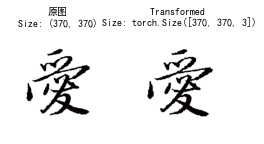

In [12]:
plot_one_transformed_image('data/wordlib/愛_行书_唐寅_28699.gif',aug_transform,save=False)

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=None,show=True,save=True,save_path='data/augmented/'):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
        save: save or not the transformed image file
        save_path: where to save the transformed image file
    """
    #random.seed(42)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        try:
            with Image.open(image_path).convert('RGB') as f:
                # 转换并显示图片
                # Note: permute() 用于进行维度交换 
                # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
                transformed_image = transform(f).permute(1, 2, 0) 
                if transformed_image.shape[2]==1:
                    transformed_image=transformed_image.squeeze(2)
                if save:
                    img=torchvision.transforms.ToPILImage()(transformed_image.permute(2,0,1))
                    filename=image_path.name.split('.')[0]+'_'+str(random.randint(100000,999999))+'_aug.'+image_path.name.split('.')[1]   
                    #print(f'生成了新的增广变形文件{filename}')
                    img.save(f'{save_path}/{filename}')

                if show:
                    fig, ax = plt.subplots(1, 2)
                    ax[0].imshow(f) 
                    ax[0].set_title(f"Original \nSize: {f.size}")
                    ax[0].axis("off")    

                    ax[1].imshow(transformed_image)
                    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
                    ax[1].axis("off")
                    word_class=image_path.name.split('_')[0]
                    fig.suptitle(f"Class: {word_class}, label is :{word_classes_dict[word_class]}", fontsize=16,fontproperties='Simhei')
            
        except:
            continue

### 从已有的图片中增广生成新图片并保存

In [14]:
def generate_augmented_images(k=2,size=4,image_path_list=None,aug_transform=None,save=True,show=False,save_path='data/augmented/')->None:
    """
    使用转换器随机生成增广图片并保存
    生成图片数量为：k*size
    
    Args:
        k=2:循环生成的次数
        size=4：每次取样的大小
        image_path_list=IMAGE_PATH_LIST：图片来源文件夹
        aug_transform=None：转换器
        save=True：是否保存到文件夹
        show=False：是否显示生成的图片
        save_path='data/augmented/'：文件保存路径
    """
    
    for i in range(k):
        plot_transformed_images(image_path_list, 
                            transform=aug_transform, 
                            n=size,save=True,show=False,save_path='data/augmented/')

In [15]:
# generate_augmented_images(10,10,image_path_list=IMAGE_PATH_LIST,aug_transform=aug_transform) #从已有的图片中增广生成100万张图片

### 自定义继承自torch.utils.data.Dataset的数据集

In [16]:
# 自定义继承自torch.utils.data.Dataset的数据集
from torch.utils.data import Dataset

# 1. torch.utils.data.Dataset的子类
class ImageFolderWordLibDataSet(Dataset):
    
    # 2. 用targ_dir和transform (可选)参数初始化
    def __init__(self, targ_dir: str, transform = None, ext:str='gif'):
              
        # 3. 创建类属性
        # 获取文件夹下所有的图片文件全名
        self.paths = list(pathlib.Path(targ_dir).glob(f"*.{ext}")) # note: ext为文件扩展名，可以改为 .png's或.jpeg's
        # 设置transforms
        self.transform = transform
        # 创建classes和class_to_idx属性
        self.classes, self.class_to_idx,_ = find_classes(targ_dir,ext)

    # 4. 定义加载图片的函数
    def load_image(self, index: int):
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB'),image_path
    
    # 5. 覆盖 the __len__()方法 
    def __len__(self) -> int:
        "返回样本总数"
        return len(self.paths)
    
    # 6. 覆盖 __getitem__() 方法(作为torch.utils.data.Dataset子类必须重写该方法)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "根据index返回一个样本的data and label (X, y)."
        img,img_path = self.load_image(index)
        class_name  = img_path.name.split('_')[0] # 命名规则为: data_dir/word_font_writer_number.gif
        class_idx = self.class_to_idx[class_name]

        # 对图片作转换
        if self.transform:
            return self.transform(img), class_idx # 返回样本data, label (X, y)
        else:
            return img, class_idx # 返回样本 data, label (X, y)

In [17]:
# 对train data作转换
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# 对test data只须统一shape并转换为Tensor
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 实例化自定义的数据集对象，并拆分为训练集和测试集

In [18]:
#实例化自定义的数据集对象，并拆分为训练集和测试集
data_custom = ImageFolderWordLibDataSet(targ_dir=IMAGE_PATH, 
                                        transform=train_transforms,
                                        ext='gif')
train_size=int(0.9*len(data_custom))
test_size=len(data_custom)-train_size
torch.manual_seed(42)
train_dataset,test_dataset=torch.utils.data.random_split(data_custom,[train_size,test_size])

train_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x119884af6a0>,
 <torch.utils.data.dataset.Subset at 0x119884af640>)

In [19]:
len(data_custom),len(train_dataset),len(test_dataset),len(train_dataset)+len(test_dataset)

(1186561, 1067904, 118657, 1186561)

###  创建随机显示图片的函数

In [20]:
# 1. 输入参数为dataset、文字列表
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. 为了好的显示效果，只允许显示10张
    if n > 10:
        n = 10
        display_shape = False
        print(f"为了好的显示效果，最多只允许显示10张图片.")
    
    # 3. 设置随机种子
    if seed:
        random.seed(seed)

    # 4. 获取抽样序号
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. 设置figure大小
    plt.figure(figsize=(16, 8))

    # 6. 显示每张抽取的图片
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. 用permute函数调整image的tensor shape以正确显示图片:
        # tensor的维度： [color_channels, height, width] -> 画图维度[height, width,color_channels]
        targ_image_adjust = targ_image.permute(1, 2, 0) 
        if targ_image_adjust.shape[2]==1:
            targ_image_adjust=targ_image_adjust.squeeze(2)  #如果图片只有1个通道，则需要压缩维度，去掉通道信息，否则不能正常显示
        # 将n幅图画在1行
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title,fontproperties='simhei')

为了好的显示效果，最多只允许显示10张图片.


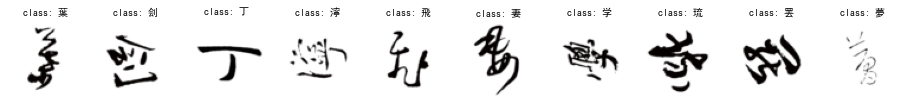

In [21]:
display_random_images(train_dataset, 
                      n=18, 
                      classes=images_classes_list,
                      seed=None)

###  用 `DataLoader`来加载自定义的数据集

In [22]:
os.cpu_count()

72

In [23]:

train_dataloader = DataLoader(dataset=train_dataset, # 使用自定义训练数据集
                                     batch_size=32, # 每批次加载多少样本
                                     num_workers=0, # 并行加载任务数 (越高越好，但不高于os.cpu_count(),0表示任务加载)
                                     shuffle=True) # 是否乱序加载?

test_dataloader = DataLoader(dataset=test_dataset, # 使用自定义测试数据集
                                    batch_size=32, 
                                    num_workers=0, 
                                    shuffle=False) # 不须乱序加载

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1198e2ffa00>,
 <torch.utils.data.dataloader.DataLoader at 0x1198e2ffb80>)

In [24]:
img, label = next(iter(train_dataloader))
# next一次加载一批
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [25]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31,fill=255), # how intense 
    #transforms.ColorJitter(brightness=.5, hue=.3),
    #transforms.RandomRotation(degrees=(0, 180),expand=False,fill=255),
    #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.7, 0.9),fill=255),
    #transforms.ElasticTransform(alpha=250.0,fill=255),
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.6,fill=255),
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# 对测试集不作增广变换
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor()
])

###  创建TinyVGG模型类

In [26]:
from torch import nn
class TinyVGG(nn.Module):
    """
    卷积神经网络的模型参考了下面的结构，该网站详细解释了该结构，并对模型参数作了很好的可视化: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # 卷积核大小
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            
            # 下面这一步的in_features设置有一定困难，如果维度计算不准，模型将报错，建议先把self.classifier这一层去掉，看前面结构的output_shape输出，
            # 再根据这个输出确定这里的in_features
            nn.Linear(in_features=hidden_units*16*16,out_features=output_shape) 
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # 这种用法效果相同且更高效

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # 颜色通道 (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(images_classes_list)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=8985, bias=True)
  )
)

In [27]:
len(images_classes_list)

8985

In [28]:
# 1. 从test_dataloader中抽取一批数据用于显示
itr=iter(test_dataloader)
img_batch, label_batch= next(itr)

In [29]:
def plot_from_image_tensor(img_tensor):
    """
    把图片tensor显示成图片
    """
    img =img_tensor.permute(1,2,0) #如果只想看某一个channel的话，再接上[:,:,0]
    if img.shape[2]==1:
        img=img.squeeze(2)
    plt.imshow(img.cpu())  #对于在GPU上的数据集，需要调用.cpu()才能plot
    plt.axis(False)

In [30]:
def result_compare(iterator,model):
    model.eval()
    with torch.inference_mode():
        image_batch, label_batch = next(iterator)
        image_batch=image_batch.to(device)
        pred_label=torch.argmax(model(image_batch),dim=1)
        #print(model_0(image_batch).shape,pred_label,label_batch)
        word_dict=dict()
        label_dict=dict()         
        fig, ax = plt.subplots(figsize=(12,6)) 
        ax.axis(False)
        for i in range(len(label_batch)):
            pred_word=images_classes_list[pred_label[i]]
            word=images_classes_list[label_batch[i]]
            ax = fig.add_subplot(4,8,i+1)
            plot_from_image_tensor(image_batch[i])
            word_dict[word] = pred_word
            label_dict[label_batch[i]]=pred_label[i]
            pred_compare=pd.DataFrame.from_dict(word_dict,orient='index')
            pred_compare.reset_index(inplace=True)
            pred_compare.columns=['实际汉字','识别结果']
    return pred_compare

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
实际汉字,靈,鍵,問,棚,訓,不,震,而,秽,俯,...,怕,碾,皿,散,岸,度,濁,听,复,忍
识别结果,鬆,鬆,鬆,鬆,鬆,鬆,鬆,鬆,鬆,鬆,...,鬆,鬆,鬆,鬆,鬆,鬆,鬆,鬆,鬆,鬆


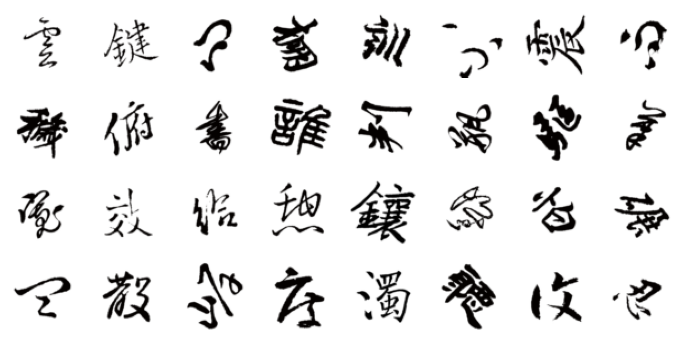

In [31]:
result=result_compare(itr,model_0)
result.T

### 使用`torchinfo`来获得模型信息

In [32]:
# torchinfo这个包可以比较方便地显示模型结构和参数，如果import失败，需要安装
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=img_batch.shape) # summary函数非常方便，只需要把一个batch的shape作为输入就能够得模型信息，不须加载真实数据

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 8985]                --
├─Sequential: 1-1                        [32, 20, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 20, 64, 64]          560
│    └─ReLU: 2-2                         [32, 20, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 20, 64, 64]          3,620
│    └─ReLU: 2-4                         [32, 20, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 20, 32, 32]          --
├─Sequential: 1-2                        [32, 20, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 20, 32, 32]          3,620
│    └─ReLU: 2-7                         [32, 20, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 20, 32, 32]          3,620
│    └─ReLU: 2-9                         [32, 20, 32, 32]          --
│    └─MaxPool2d: 2-10                   [32, 20, 16, 16]          --
├─Seq

###  创建train_step和test_step函数
主要定义了三个函数:
1. `train_step()` - 输入参数为：model, `DataLoader`，loss function和optimizer
2. `test_step()` - 输入参数为：model, `DataLoader`，loss function和optimizer
3. `train()` - 定义train Loop，执行给定的epochs并返回一个结果集的dict.

* 模型训练的标准流程：
    * 0-上device
    * 1-model(x)前向算结果
    * 2-loss_fn根据结果算损失
    * 3-zero_grad梯度全归零
    * 4-backword反向传播算梯度
    * 5-step更新参数    

In [33]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # model进入训练模式
    model.train()
    
    # 设置 train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # 对data loader的每个data批次进行训练。假如训练集有10000个数据，batch size为32的话，则有 (10000/32)=312.5经向上取整后共313个批次
    # 但这不用手动计算，将dataloader放到enumerate()函数中会自动循环获取
    # 有些代码也会使用iter(dataloader)进行循环，区别在于iter不会返回批次的序号
    
    # 0-5步为模型训练的标准流程：
    '''
    0-上device
    1-前向算结果
    2-根据结果算损失
    3-zero_grad梯度全归零
    4-backword反向传播算梯度
    5-step更新参数
    '''
    
    for batch, (X, y) in enumerate(dataloader):
        # 0. 把数据放到目标device上
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()   #loss_fn返回的是tensor，调用.item()转换为numpy的值

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # 6. Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # 计算每批次loss和accuracy的平均数
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [34]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # 开启test模式，有些dropout的层将跳过
    model.eval() 
    
    # 设置 test loss 和 test accuracy为0
    test_loss, test_acc = 0, 0
    
    # 不会进行梯度计算，以加快运行速度
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # 计算每个test batch平均损失和准确度
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 创建训练Loop:将train_step()和test_step()放在train()函数中 

1. 传入参数：model, 封装了训练集和测试集的`DataLoader`，优化器optimizer, 损失函数loss_fn，训练和测试的循环次数epochs
2. 创建空的`train_loss`, `train_acc`, `test_loss` , `test_acc` 字典
3. 对epoches中的每个epoch循环运行train()和test().
4. 输出每个epoch的过程信息.
5. 更新每个epoch的metrics字典.
6. 返回结果


In [35]:
# 1. 定义train函数和传入参数
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. 创建空字典用于存储结果
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Training循环
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        # 4. 输出结果
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. 更新结果字典
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. 训练结束返回结果
    return results

In [36]:
# 设置随机种子
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# 设置epochs次数
NUM_EPOCHS = 50 
# 实例化模型
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(data_custom.classes)).to(device)

# 设置损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# 用timer开始计时

start_time = timer()

# 开始训练模型model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# 训练结束，输出训练时长
end_time = timer()
print(f"训练时长: {end_time-start_time:.3f} seconds")

  2%|█▍                                                                        | 1/50 [8:01:04<392:52:56, 28864.82s/it]

Epoch: 1 | train_loss: 8.1356 | train_acc: 0.0125 | test_loss: 7.6767 | test_acc: 0.0295


  4%|██▉                                                                       | 2/50 [9:00:34<283:40:55, 21276.16s/it]

Epoch: 2 | train_loss: 6.5390 | train_acc: 0.0825 | test_loss: 6.9065 | test_acc: 0.0653


  6%|████▍                                                                    | 3/50 [10:00:03<208:25:07, 15963.99s/it]

Epoch: 3 | train_loss: 5.1754 | train_acc: 0.1820 | test_loss: 6.8704 | test_acc: 0.0899


  8%|█████▊                                                                   | 4/50 [10:59:31<156:28:04, 12245.31s/it]

Epoch: 4 | train_loss: 4.5765 | train_acc: 0.2414 | test_loss: 6.7201 | test_acc: 0.1006


 10%|███████▍                                                                  | 5/50 [11:58:59<120:31:38, 9642.18s/it]

Epoch: 5 | train_loss: 4.1215 | train_acc: 0.2917 | test_loss: 6.6934 | test_acc: 0.1102


 12%|█████████                                                                  | 6/50 [12:58:28<95:34:42, 7820.06s/it]

Epoch: 6 | train_loss: 3.8374 | train_acc: 0.3248 | test_loss: 6.7220 | test_acc: 0.1157


 14%|██████████▌                                                                | 7/50 [13:57:55<78:10:08, 6544.39s/it]

Epoch: 7 | train_loss: 3.6344 | train_acc: 0.3495 | test_loss: 6.6159 | test_acc: 0.1153


 16%|████████████                                                               | 8/50 [14:57:25<65:56:16, 5651.83s/it]

Epoch: 8 | train_loss: 3.4799 | train_acc: 0.3689 | test_loss: 6.7522 | test_acc: 0.1244


 18%|█████████████▌                                                             | 9/50 [15:56:54<57:15:05, 5026.96s/it]

Epoch: 9 | train_loss: 3.3536 | train_acc: 0.3852 | test_loss: 6.8442 | test_acc: 0.1254


 20%|██████████████▊                                                           | 10/50 [16:56:22<50:59:41, 4589.53s/it]

Epoch: 10 | train_loss: 3.2502 | train_acc: 0.3987 | test_loss: 6.6775 | test_acc: 0.1272


 22%|████████████████▎                                                         | 11/50 [17:55:51<46:24:07, 4283.27s/it]

Epoch: 11 | train_loss: 3.1646 | train_acc: 0.4099 | test_loss: 6.7985 | test_acc: 0.1317


 24%|█████████████████▊                                                        | 12/50 [18:55:20<42:57:04, 4069.06s/it]

Epoch: 12 | train_loss: 3.1041 | train_acc: 0.4180 | test_loss: 6.6749 | test_acc: 0.1342


 26%|███████████████████▏                                                      | 13/50 [19:54:49<40:16:43, 3919.02s/it]

Epoch: 13 | train_loss: 2.9730 | train_acc: 0.4356 | test_loss: 6.7302 | test_acc: 0.1413


 28%|████████████████████▋                                                     | 14/50 [20:54:19<38:08:33, 3814.27s/it]

Epoch: 14 | train_loss: 2.8286 | train_acc: 0.4565 | test_loss: 6.6172 | test_acc: 0.1444


 30%|██████████████████████▏                                                   | 15/50 [21:53:49<36:22:15, 3741.01s/it]

Epoch: 15 | train_loss: 2.7289 | train_acc: 0.4711 | test_loss: 6.6564 | test_acc: 0.1459


 32%|███████████████████████▋                                                  | 16/50 [22:53:19<34:50:50, 3689.73s/it]

Epoch: 16 | train_loss: 2.6460 | train_acc: 0.4832 | test_loss: 6.6796 | test_acc: 0.1498


 34%|█████████████████████████▏                                                | 17/50 [23:52:49<33:29:28, 3653.60s/it]

Epoch: 17 | train_loss: 2.5791 | train_acc: 0.4930 | test_loss: 6.6530 | test_acc: 0.1479


 36%|██████████████████████████▋                                               | 18/50 [24:52:18<32:15:08, 3628.38s/it]

Epoch: 18 | train_loss: 2.5234 | train_acc: 0.5019 | test_loss: 6.7367 | test_acc: 0.1494


 38%|████████████████████████████                                              | 19/50 [25:52:04<31:08:08, 3615.75s/it]

Epoch: 19 | train_loss: 2.4725 | train_acc: 0.5097 | test_loss: 6.8301 | test_acc: 0.1470


 40%|█████████████████████████████▌                                            | 20/50 [26:51:26<29:59:45, 3599.51s/it]

Epoch: 20 | train_loss: 2.4288 | train_acc: 0.5165 | test_loss: 6.7680 | test_acc: 0.1515


 42%|███████████████████████████████                                           | 21/50 [27:50:47<28:54:09, 3587.90s/it]

Epoch: 21 | train_loss: 2.3873 | train_acc: 0.5230 | test_loss: 6.9203 | test_acc: 0.1484


 44%|████████████████████████████████▌                                         | 22/50 [28:50:07<27:50:31, 3579.69s/it]

Epoch: 22 | train_loss: 2.3524 | train_acc: 0.5285 | test_loss: 6.7945 | test_acc: 0.1518


 46%|██████████████████████████████████                                        | 23/50 [29:49:28<26:48:18, 3574.03s/it]

Epoch: 23 | train_loss: 2.3164 | train_acc: 0.5339 | test_loss: 6.7142 | test_acc: 0.1427


 48%|███████████████████████████████████▌                                      | 24/50 [30:48:49<25:47:03, 3570.14s/it]

Epoch: 24 | train_loss: 2.2869 | train_acc: 0.5383 | test_loss: 6.8151 | test_acc: 0.1492


 50%|█████████████████████████████████████                                     | 25/50 [31:48:10<24:46:21, 3567.28s/it]

Epoch: 25 | train_loss: 2.2558 | train_acc: 0.5437 | test_loss: 6.9925 | test_acc: 0.1497


 52%|██████████████████████████████████████▍                                   | 26/50 [32:47:30<23:46:02, 3565.12s/it]

Epoch: 26 | train_loss: 2.2295 | train_acc: 0.5470 | test_loss: 6.9759 | test_acc: 0.1497


 54%|███████████████████████████████████████▉                                  | 27/50 [33:46:50<22:46:05, 3563.70s/it]

Epoch: 27 | train_loss: 2.2027 | train_acc: 0.5522 | test_loss: 6.9925 | test_acc: 0.1461


 56%|█████████████████████████████████████████▍                                | 28/50 [34:46:11<21:46:23, 3562.87s/it]

Epoch: 28 | train_loss: 2.1791 | train_acc: 0.5551 | test_loss: 7.0132 | test_acc: 0.1485


 58%|██████████████████████████████████████████▉                               | 29/50 [35:45:32<20:46:50, 3562.39s/it]

Epoch: 29 | train_loss: 2.1541 | train_acc: 0.5594 | test_loss: 6.9961 | test_acc: 0.1495


 60%|████████████████████████████████████████████▍                             | 30/50 [36:44:54<19:47:22, 3562.14s/it]

Epoch: 30 | train_loss: 2.1346 | train_acc: 0.5626 | test_loss: 7.1270 | test_acc: 0.1521


 62%|█████████████████████████████████████████████▉                            | 31/50 [37:44:15<18:47:52, 3561.73s/it]

Epoch: 31 | train_loss: 2.1137 | train_acc: 0.5658 | test_loss: 7.3037 | test_acc: 0.1479


 64%|███████████████████████████████████████████████▎                          | 32/50 [38:43:36<17:48:30, 3561.69s/it]

Epoch: 32 | train_loss: 2.0934 | train_acc: 0.5691 | test_loss: 7.1347 | test_acc: 0.1508


 66%|████████████████████████████████████████████████▊                         | 33/50 [39:42:58<16:49:06, 3561.57s/it]

Epoch: 33 | train_loss: 2.0750 | train_acc: 0.5721 | test_loss: 7.3711 | test_acc: 0.1439


 68%|██████████████████████████████████████████████████▎                       | 34/50 [40:42:19<15:49:45, 3561.60s/it]

Epoch: 34 | train_loss: 2.0554 | train_acc: 0.5752 | test_loss: 7.1007 | test_acc: 0.1503


 70%|███████████████████████████████████████████████████▊                      | 35/50 [41:41:41<14:50:22, 3561.52s/it]

Epoch: 35 | train_loss: 2.0385 | train_acc: 0.5781 | test_loss: 7.2493 | test_acc: 0.1472


 72%|█████████████████████████████████████████████████████▎                    | 36/50 [42:41:02<13:51:02, 3561.58s/it]

Epoch: 36 | train_loss: 2.0226 | train_acc: 0.5804 | test_loss: 7.2909 | test_acc: 0.1512


 74%|██████████████████████████████████████████████████████▊                   | 37/50 [43:40:24<12:51:39, 3561.49s/it]

Epoch: 37 | train_loss: 2.0064 | train_acc: 0.5833 | test_loss: 7.2674 | test_acc: 0.1514


 76%|████████████████████████████████████████████████████████▏                 | 38/50 [44:39:46<11:52:20, 3561.69s/it]

Epoch: 38 | train_loss: 1.9917 | train_acc: 0.5856 | test_loss: 7.6214 | test_acc: 0.1492


 78%|█████████████████████████████████████████████████████████▋                | 39/50 [45:39:07<10:52:57, 3561.56s/it]

Epoch: 39 | train_loss: 1.9771 | train_acc: 0.5884 | test_loss: 7.6392 | test_acc: 0.1463


 80%|████████████████████████████████████████████████████████████               | 40/50 [46:38:28<9:53:33, 3561.39s/it]

Epoch: 40 | train_loss: 1.9624 | train_acc: 0.5905 | test_loss: 7.3875 | test_acc: 0.1481


 82%|█████████████████████████████████████████████████████████████▍             | 41/50 [47:37:50<8:54:13, 3561.55s/it]

Epoch: 41 | train_loss: 1.9481 | train_acc: 0.5929 | test_loss: 7.4376 | test_acc: 0.1447


 84%|███████████████████████████████████████████████████████████████            | 42/50 [48:37:25<7:55:23, 3565.44s/it]

Epoch: 42 | train_loss: 1.9368 | train_acc: 0.5948 | test_loss: 7.3440 | test_acc: 0.1448


 86%|████████████████████████████████████████████████████████████████▌          | 43/50 [49:36:56<6:56:11, 3567.40s/it]

Epoch: 43 | train_loss: 1.9247 | train_acc: 0.5970 | test_loss: 7.4915 | test_acc: 0.1484


 88%|██████████████████████████████████████████████████████████████████         | 44/50 [50:36:18<5:56:34, 3565.72s/it]

Epoch: 44 | train_loss: 1.9114 | train_acc: 0.5990 | test_loss: 7.6563 | test_acc: 0.1474


 90%|███████████████████████████████████████████████████████████████████▌       | 45/50 [51:35:40<4:57:02, 3564.42s/it]

Epoch: 45 | train_loss: 1.9015 | train_acc: 0.6008 | test_loss: 7.7097 | test_acc: 0.1480


 92%|█████████████████████████████████████████████████████████████████████      | 46/50 [52:35:02<3:57:34, 3563.65s/it]

Epoch: 46 | train_loss: 1.8888 | train_acc: 0.6020 | test_loss: 7.4926 | test_acc: 0.1524


 94%|██████████████████████████████████████████████████████████████████████▌    | 47/50 [53:34:23<2:58:08, 3562.93s/it]

Epoch: 47 | train_loss: 1.8806 | train_acc: 0.6043 | test_loss: 7.5583 | test_acc: 0.1507


 96%|████████████████████████████████████████████████████████████████████████   | 48/50 [54:33:44<1:58:44, 3562.40s/it]

Epoch: 48 | train_loss: 1.8693 | train_acc: 0.6064 | test_loss: 7.6435 | test_acc: 0.1499


 98%|███████████████████████████████████████████████████████████████████████████▍ | 49/50 [55:33:05<59:22, 3562.10s/it]

Epoch: 49 | train_loss: 1.8577 | train_acc: 0.6083 | test_loss: 7.6413 | test_acc: 0.1452


100%|█████████████████████████████████████████████████████████████████████████████| 50/50 [56:32:27<00:00, 4070.95s/it]

Epoch: 50 | train_loss: 1.8503 | train_acc: 0.6096 | test_loss: 7.6860 | test_acc: 0.1487
训练时长: 203530.470 seconds


### 查看预测结果

In [37]:
model_0_df = pd.DataFrame(model_0_results) 
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,8.135587,0.012451,7.676735,0.029481
1,6.538998,0.082493,6.906492,0.065348
2,5.175401,0.182004,6.870378,0.089925
3,4.576468,0.241403,6.720143,0.100625
4,4.121474,0.291689,6.693403,0.110213
5,3.837356,0.324841,6.721961,0.115665
6,3.634355,0.349531,6.615856,0.115328
7,3.479874,0.368879,6.752216,0.124410
8,3.353639,0.385154,6.844202,0.125354
9,3.250194,0.398696,6.677543,0.127207


### 绘制训练过程曲线

In [38]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """绘制训练过程曲线.

    Args:
        results (dict): 训练过程记录dict,包括：
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # 获取Train和test过程的loss值
    loss = results['train_loss']
    test_loss = results['test_loss']

    # 获取train和test过程的准确度acc值
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # 获取训练经历的epoches
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss-损失', fontsize=16,fontproperties='Simhei')
    plt.xlabel('Epochs-训练轮次', fontsize=16,fontproperties='Simhei')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy-')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy-准确度', fontsize=16,fontproperties='Simhei')
    plt.xlabel('Epochs-训练轮次', fontsize=16,fontproperties='Simhei')
    plt.legend();

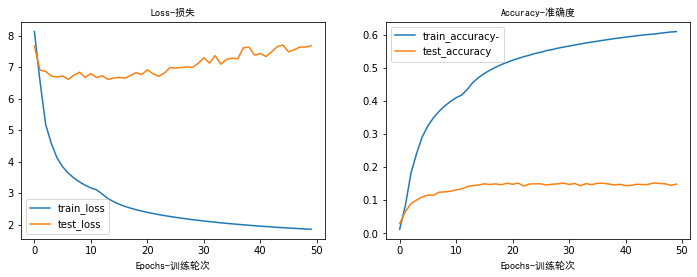

In [39]:
plot_loss_curves(model_0_results) 

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
实际汉字,国,灰,闾,偿,鼎,送,佣,宜,焉,旧,...,贱,篤,蹶,排,燒,井,辐,祜,寒,軸
识别结果,图,哀,閭,仪,里,道,佣,時,曾,舊,...,賤,菜,綫,排,说,井,壑,袖,斗,贱


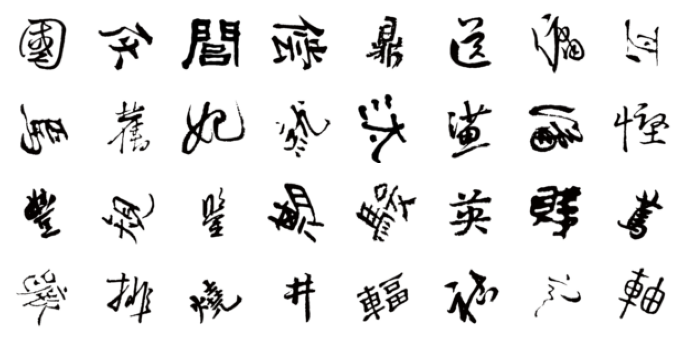

In [40]:
result=result_compare(itr,model_0)
result.T

###  保存和加载训练好的模型
* `torch.save` - 保存PyTorch模型或模型的参数`state_dict()`. 
* `torch.load` - 加载已保存的PyTorch对象.
* `torch.nn.Module.load_state_dict()` - 加载通过保存的`state_dict()`模型参数到新的model实例中.

In [41]:
from pathlib import Path

# 创建用于保存模型的文件夹(如果已存在则不操作), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("data/models")
MODEL_PATH.mkdir(parents=True, #  
                 exist_ok=True # 如果路径存在也不报错
)

MODEL_NAME = "CalligraphyRegTinyVGG.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
 

In [42]:
# 保存模型的state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=model_0.state_dict(), # 只保存state_dict()中可学习的参数
           f=MODEL_SAVE_PATH)


Saving model to: data\models\CalligraphyRegTinyVGG.pth


In [43]:
# 创建一个和保存的参数具有相同结构的模型实例，否则会报错
loaded_model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(data_custom.classes))
# 加载state_dict()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH,map_location=torch.device(device)))

# 将模型发送到相应的device
loaded_model_0 = loaded_model_0.to(device)

In [44]:
print(type(loaded_model_0.state_dict()))  # 查看state_dict所返回的类型，是一个“顺序字典OrderedDict”
 
for param_tensor in loaded_model_0.state_dict(): # 字典的遍历默认是遍历 key，所以param_tensor实际上是键值
    print(param_tensor,'\t',loaded_model_0.state_dict()[param_tensor].shape) 

<class 'collections.OrderedDict'>
conv_block_1.0.weight 	 torch.Size([20, 3, 3, 3])
conv_block_1.0.bias 	 torch.Size([20])
conv_block_1.2.weight 	 torch.Size([20, 20, 3, 3])
conv_block_1.2.bias 	 torch.Size([20])
conv_block_2.0.weight 	 torch.Size([20, 20, 3, 3])
conv_block_2.0.bias 	 torch.Size([20])
conv_block_2.2.weight 	 torch.Size([20, 20, 3, 3])
conv_block_2.2.bias 	 torch.Size([20])
classifier.1.weight 	 torch.Size([8985, 5120])
classifier.1.bias 	 torch.Size([8985])


In [45]:
for i,param in enumerate(loaded_model_0.parameters()):
    print(i,param.shape)

0 torch.Size([20, 3, 3, 3])
1 torch.Size([20])
2 torch.Size([20, 20, 3, 3])
3 torch.Size([20])
4 torch.Size([20, 20, 3, 3])
5 torch.Size([20])
6 torch.Size([20, 20, 3, 3])
7 torch.Size([20])
8 torch.Size([8985, 5120])
9 torch.Size([8985])


### 使用预训练模型作预测

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
实际汉字,建,處,伤,新,寓,察,昼,笑,蝉,詐,...,则,臉,加,舛,辈,卧,岸,寺,局,隘
识别结果,尽,币,敌,新,似,罂,儘,束,吟,说,...,野,诫,君,门,姜,保,具,音,两,缀


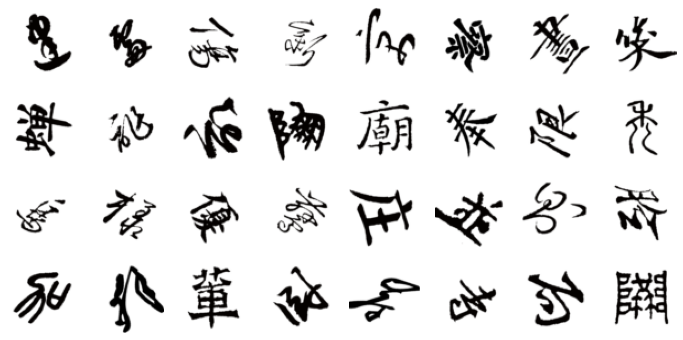

In [46]:
result=result_compare(itr,loaded_model_0)
result.T

In [47]:
def get_image_by_file_name(image_path,show=True)->(str,str,Image):
    
    '''
    定义函数 get_image_by_file_name，根据图片文件名返回图片内容，并显示该图片
    Args:
        image_path (str): 文字图片路径和文件名.
        show (Boolean): 是否显示文字图片

    Returns:
        img:图片内容

    Example:
        data\wordlib\予_行书_鲜于枢_12046.gif "_"前面的字符是书法对应的文字
        
    '''  
    print(image_path)
    img=Image.open(image_path).convert('RGB')  #    丁_草书_王铎_131029.gif data/wordlib/zxqsig.jpg
    if show:
            plt.figure(figsize=(2, 2)) 
            plt.imshow(img)  
            plt.title(f"图片size(H,W)为:({img.height}, {img.width})",fontsize=16,fontproperties='Simhei')
            plt.axis(False)    
    return img

In [48]:
def predict_by_image_name(image_path,model):
    model.eval()
    with torch.inference_mode():
        query_image=get_image_by_file_name(image_path,show=True)        
        img=test_transforms(query_image).unsqueeze(0).to(device)
        pred_label=torch.argmax(model(img),dim=1)        
        print(f'\n图片文字预测为:\"{images_classes_list[pred_label]}\"，其Label为{pred_label.item()}')

data\test\13266_600465_aug.gif

图片文字预测为:"作"，其Label为193


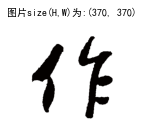

In [49]:
predict_by_image_name(r'data\test\13266_600465_aug.gif',loaded_model_0)

###  更多参考

* PyTorch `Dataset` and `DataLoader`[datasets and dataloaders tutorial notebook](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).
* PyTorch `torchvision.transforms`[ documentation](https://pytorch.org/vision/stable/transforms.html).
* Demos of `transforms` in action in the [illustrations of transforms tutorial](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#illustration-of-transforms). 
* PyTorch [`torchvision.datasets` documentation](https://pytorch.org/vision/stable/datasets.html).